In [1]:
import numpy as np
import nibabel as nib
from nilearn import image, plotting, regions

In [2]:
%matplotlib inline

In [4]:
corrmat = np.load('/home/despoB/dlurie/Projects/despolab_lesion/control_data/hcp/sub-100307/func/sub-100307_task-rest_acq-LR_run-01_bold_space-MNI_corrmat_atlas-BNA_wbsreg.npy')

In [7]:
np.savetxt('corrmat_single.csv', corrmat)

In [87]:
from glob import glob

In [89]:
hcp_mat_paths = glob('/home/despoB/dlurie/Projects/despolab_lesion/control_data/hcp/sub-*/func/sub-*_task-rest_acq-LR_run-01_bold_space-MNI_corrmat_atlas-BNA_wbsreg.npy')

In [110]:
hcp_mats = []
for i in hcp_mat_paths:
    tmat = np.load(i)
    tmat = np.arctanh(tmat)
    hcp_mats.append(tmat)

/home/despoB/dlurie/anaconda3/envs/sandbox/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in arctanh
  after removing the cwd from sys.path.


In [112]:
hcp_array = np.stack(hcp_mats)

In [102]:
hcp_array.shape

(100, 246, 246)

In [113]:
hcp_mean = np.mean(hcp_array, axis=0)

In [114]:
hcp_mean.shape

(246, 246)

In [116]:
np.savetxt('hcp_mean_mat_z.txt', hcp_mean)

#### Convert the 3D parcellation into a 4D set of ROIs and get the center of mass for each one.

In [11]:
bna_path = '/home/despoB/dlurie/Data/reference/Brainnetome/BNA-maxprob-thr25-2mm.nii.gz'

In [12]:
bna_img = nib.load(bna_path)

In [13]:
range(1,10)

range(1, 10)

In [14]:
img_stack = []
bna_data = bna_img.get_data()
for idx in range(1,247):
    roi_img = bna_data == idx
    img_stack.append(roi_img)
img_stack = np.array(img_stack)

In [15]:
img_list = []
for idx in range(246):
    roi_img = image.new_img_like(bna_img, img_stack[idx])
    img_list.append(roi_img)

In [16]:
bna_4D = image.concat_imgs(img_list)

In [17]:
coord_list = []
for roi_img in img_list:
    coord_list.append(plotting.find_xyz_cut_coords(roi_img))

In [74]:
np.save('bna_coords.txt', coord_list)

In [3]:
coord_list = np.load('bna_coords.txt.npy')

/home/despoB/dlurie/anaconda3/envs/sandbox/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


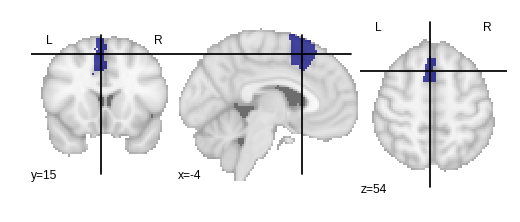

In [75]:
plotting.plot_roi(image.index_img(bna_4D, 0))

In [76]:
bna_4D.to_filename('bna_2mm_4D.nii.gz')

In [4]:
bna_4D = nib.load('bna_2mm_4D.nii.gz')

In [107]:
import seaborn as sns
sns.set(style='white')

In [6]:
import matplotlib.pyplot as plt

In [7]:
def prepare_communities_NCT(membership_list):
    n_communities = len(np.unique(membership_list))
    color_pallette = sns.color_palette("muted", n_communities).as_hex()
    module_colors = np.empty(246, dtype='object')
    for mod_id in range(1, n_communities+1):
        module_colors[membership_list == mod_id] = color_pallette[mod_id-1]
    return module_colors, color_pallette

In [21]:
def plot_connectograph(corr_mat, module_colors):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
    ms = ax1.matshow(corr_mat, interpolation="nearest",
               vmax=1, vmin=-1, cmap='RdBu_r')
    plt.colorbar(ms, ax=ax1)
    plotting.plot_connectome(corr_mat, coord_list, node_size=50, edge_cmap='RdBu_r',
                             node_color=list(module_colors), edge_threshold='99.999%', axes=ax2)

In [23]:
import warnings
warnings.filterwarnings("ignore")

# Louvain Signed - NCT

In [10]:
node_memberships_NCT = np.loadtxt('/home/despoB/dlurie/Projects/despolab_lesion/sandbox/hcp_mean_consensus_partition-louvain_gamma-1.0.txt')

In [109]:
colors_NCT, pallette_NCT = prepare_communities_NCT(node_memberships_NCT)

In [110]:
reordered_mat_NCT = np.loadtxt('/home/despoB/dlurie/Projects/despolab_lesion/sandbox/hcp_mean_corr_mat_reordered-louvain_gamma-1.0.txt').reshape(246,246)

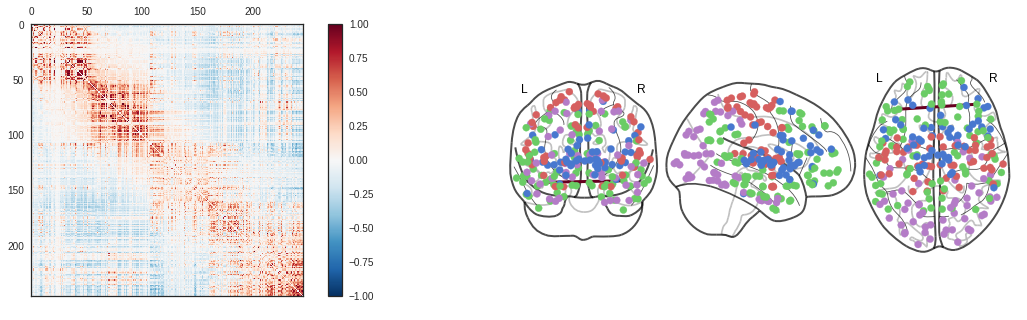

In [111]:
plot_connectograph(reordered_mat_NCT, colors_NCT)

In [112]:
pc_NCT = np.loadtxt('/home/despoB/dlurie/Projects/despolab_lesion/sandbox/hcp_mean_pc-louvain_gamma-1.0.txt')

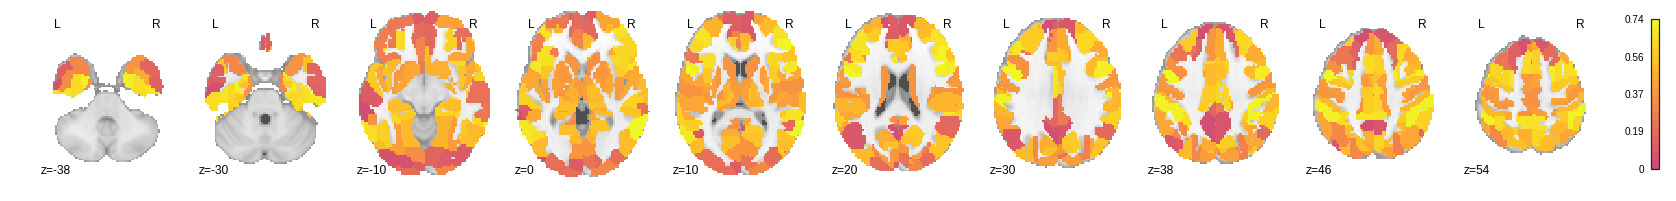

In [113]:
pc_vol_img_NCT = regions.signals_to_img_maps(pc_NCT, bna_4D)
plotting.plot_stat_map(pc_vol_img_NCT, display_mode='z', cut_coords=10, cmap='plasma')

In [114]:
wmdz_NCT = np.loadtxt('/home/despoB/dlurie/Projects/despolab_lesion/sandbox/hcp_mean_wmdz-louvain_gamma-1.0.txt')

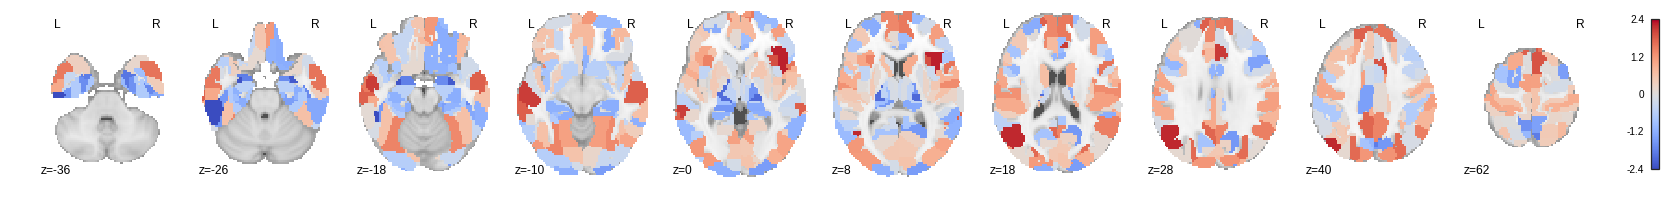

In [115]:
wmdz_vol_img_NCT = regions.signals_to_img_maps(wmdz_NCT, bna_4D)
plotting.plot_stat_map(wmdz_vol_img_NCT, display_mode='z', cut_coords=10, cmap='coolwarm')

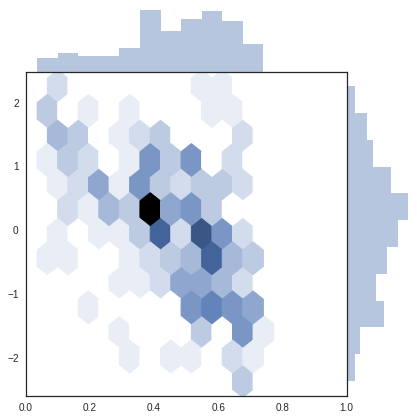

In [118]:
sns.jointplot(pc_NCT, wmdz_NCT, kind='hex', space=0, stat_func=None, xlim=(0,1))

# Louvain Signed - BCT

In [66]:
node_memberships_BCT = np.loadtxt('/home/despoB/dlurie/Projects/despolab_lesion/sandbox/BCT_Tau05_consensus_partition-louvain_gamma-1.0.txt')

In [67]:
colors_BCT, pallette_BCT = prepare_communities_NCT(node_memberships_BCT)

In [68]:
reordered_mat_BCT = np.loadtxt('/home/despoB/dlurie/Projects/despolab_lesion/sandbox/BCT_Tau05_corr_mat_reordered-louvain_gamma-1.0.txt').reshape(246,246)

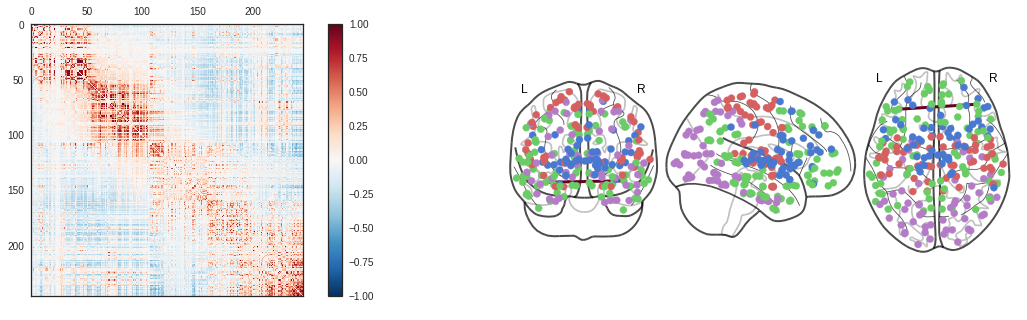

In [116]:
plot_connectograph(reordered_mat_BCT, colors_BCT)

In [70]:
pc_BCT = np.loadtxt('/home/despoB/dlurie/Projects/despolab_lesion/sandbox/BCT_Tau05_pc-louvain_gamma-1.0.txt')

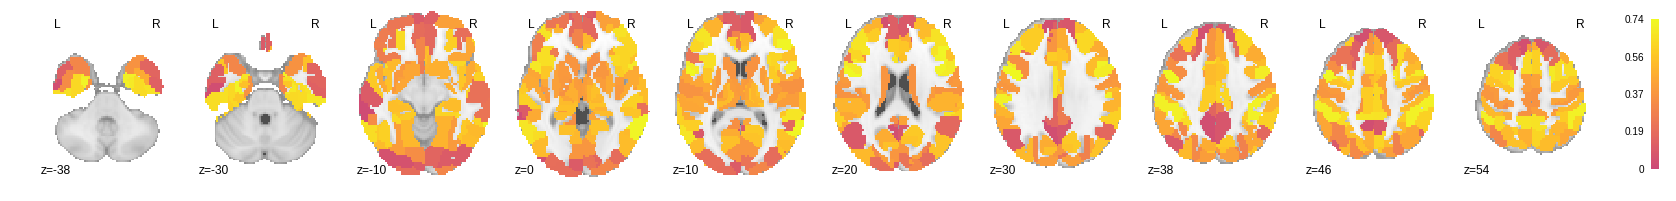

In [71]:
pc_vol_img_BCT = regions.signals_to_img_maps(pc_BCT, bna_4D)
plotting.plot_stat_map(pc_vol_img_BCT, display_mode='z', cut_coords=10, cmap='plasma')

In [73]:
wmdz_BCT = np.loadtxt('/home/despoB/dlurie/Projects/despolab_lesion/sandbox/BCT_Tau05_wmdz-louvain_gamma-1.0.txt')

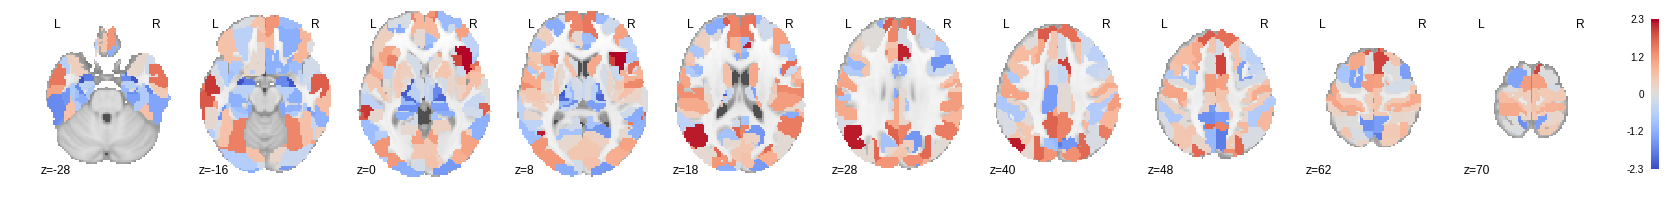

In [75]:
wmdz_vol_img_BCT = regions.signals_to_img_maps(wmdz_BCT, bna_4D)
plotting.plot_stat_map(wmdz_vol_img_BCT, display_mode='z', cut_coords=10, cmap='coolwarm')

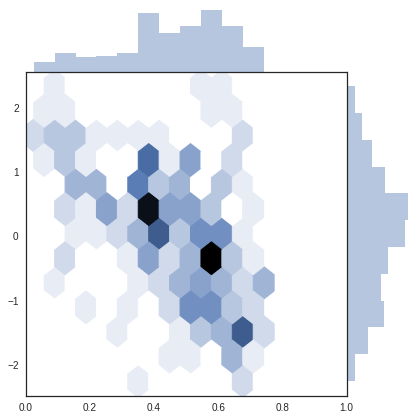

In [106]:
sns.jointplot(pc_BCT, wmdz_BCT, kind='hex', space=0, stat_func=None, xlim=(0,1))

### Infomap

In [79]:
node_memberships_infomap = np.loadtxt('/home/despoB/dlurie/Projects/despolab_lesion/sandbox/hcp_mean_best_partition-infomap_trials-250_NonNeg.txt')

In [80]:
colors_infomap, pallette_infomap = prepare_communities_NCT(node_memberships_infomap)

In [81]:
reordered_mat_infomap = np.loadtxt('/home/despoB/dlurie/Projects/despolab_lesion/sandbox/hcp_mean_corr_mat_reordered-infomap_NonNeg.txt').reshape(246,246)

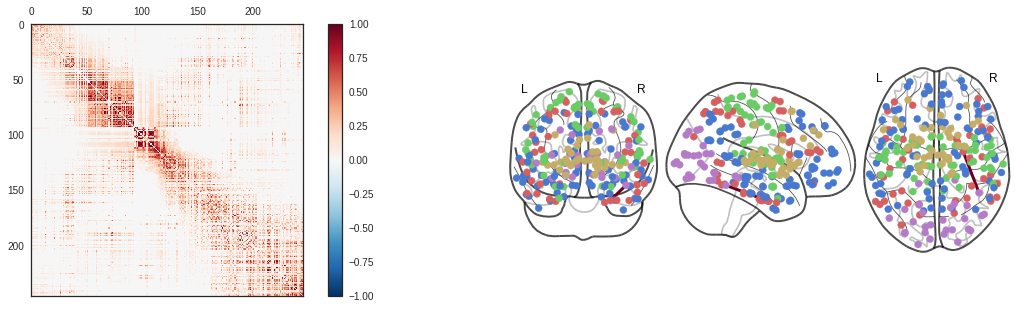

In [117]:
plot_connectograph(reordered_mat_infomap, colors_infomap)

In [83]:
pc_infomap = np.loadtxt('/home/despoB/dlurie/Projects/despolab_lesion/sandbox/hcp_mean_pc-infomap.txt')

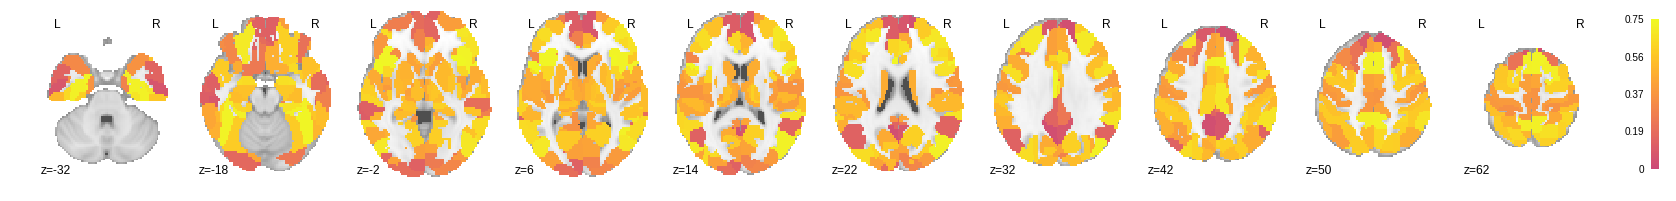

In [84]:
pc_vol_img_infomap = regions.signals_to_img_maps(pc_infomap, bna_4D)
plotting.plot_stat_map(pc_vol_img_infomap, display_mode='z', cut_coords=10, cmap='plasma')

In [85]:
wmdz_infomap = np.loadtxt('/home/despoB/dlurie/Projects/despolab_lesion/sandbox/hcp_mean_wmdz-infomap.txt')

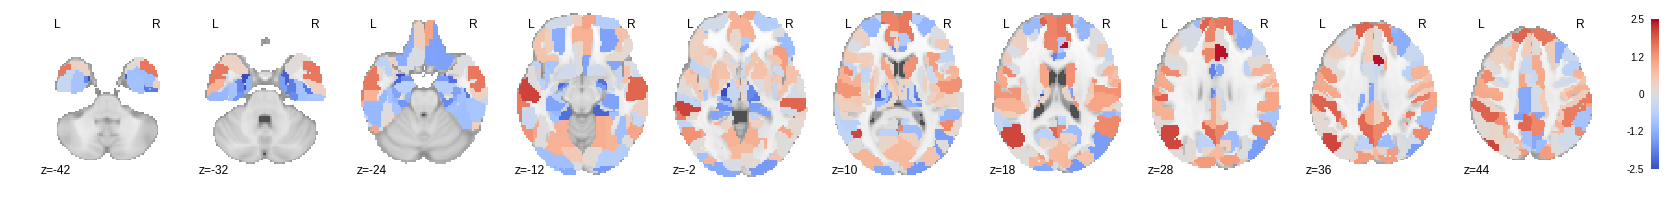

In [86]:
wmdz_vol_img_infomap = regions.signals_to_img_maps(wmdz_infomap, bna_4D)
plotting.plot_stat_map(wmdz_vol_img_infomap, display_mode='z', cut_coords=10, cmap='coolwarm')

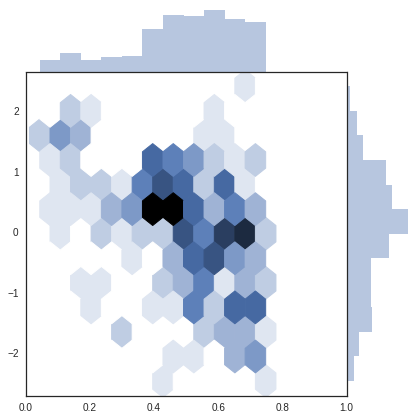

In [108]:
sns.jointplot(pc_infomap, wmdz_infomap, kind='hex', space=0, stat_func=None, xlim=(0,1))

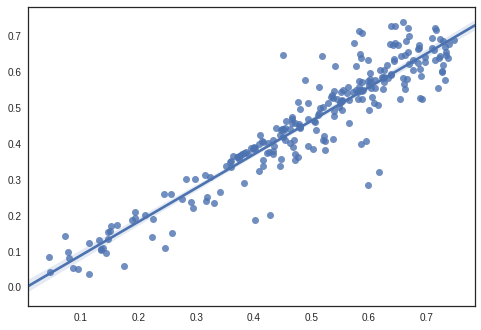

In [120]:
sns.regplot(pc_infomap, pc_NCT)

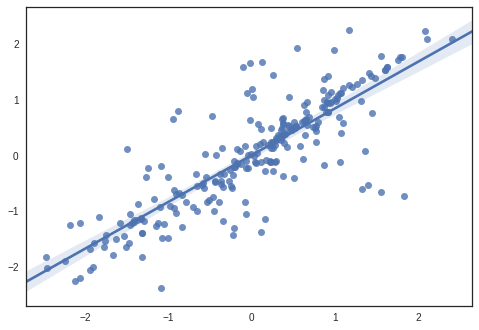

In [121]:
sns.regplot(wmdz_infomap, wmdz_NCT)